In [2]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, roc_auc_score, recall_score, precision_score
import matplotlib.pyplot as plt
from sklearn.utils import class_weight, resample
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTENC

data = pd.read_csv("../data/data_imputed.csv")
#drop values where other_cancer is equal to don't know
data = data[data.other_cancer != "Don't know / Not Sure / Refused / Missing"]

#get index of categorical features
cat_cols = data.select_dtypes(include='object').columns
cat_cols_idx = [col in cat_cols for col in data.columns]

label_encoders = {}
for column in data.columns:
    if data[column].dtype == 'object':
        le = LabelEncoder()
        data[column] = le.fit_transform(data[column])
        label_encoders[column] = le
del column, label_encoders, le

target = 'other_cancer'
X = data.drop(target, axis=1)  # Features (all columns except the target)
y = data[target]  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
def decision_tree(X_train, X_test, y_train, y_test, class_weight=None, return_clf = False):
    if class_weight is None:
        clf = DecisionTreeClassifier()
    else:
        clf = DecisionTreeClassifier(class_weight=class_weight)
    # Train the model
    clf.fit(X_train, y_train)

    # Make predictions
    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test)[:, 1]

    model_results(y_pred, y_test, y_pred_proba)

    if return_clf:
        return clf
    

def random_forest(X_train, X_test, y_train, y_test, class_weight=None, return_clf = False):
    if class_weight is None:
        clf = RandomForestClassifier(n_estimators=100, random_state=42)
    else:
        clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight=class_weight)

    # Train the model
    clf.fit(X_train, y_train)
    y_pred_proba = clf.predict_proba(X_test)[:, 1]

    # Make predictions
    y_pred = clf.predict(X_test)

    model_results(y_pred, y_test, y_pred_proba)

    if return_clf:
        return clf
        
def model_results(y_pred, y_test, y_pred_proba):
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.2f}")

    #calculate f1 score
    f1 = f1_score(y_test, y_pred, average='macro')
    print("F1 score:", f1)

    roc_auc = roc_auc_score(y_test, y_pred_proba)
    print('ROC AUC score:', roc_auc)

    sensitivity = recall_score(y_test, y_pred)
    print('Sensitivity:', sensitivity)  

    precision = precision_score(y_test, y_pred)
    print('Precision:', precision)

    report = classification_report(y_test, y_pred)
    print(report)

    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(cm)
    

def feature_importance(clf):
    importances = clf.feature_importances_

    # Print the name and importance of each feature
    for feature_name, importance in sorted(zip(importances, X.columns), reverse=True):
        print(f"{feature_name}: {importance}")

    # Sort the feature importances in descending order
    indices = np.argsort(importances)[::-1]

    # Rearrange feature names so they match the sorted feature importances
    names = [X.columns[i] for i in indices]

    # Create plot
    plt.figure()

    # Create plot title
    plt.title("Feature Importance")

    # Add bars
    plt.bar(range(X.shape[1]), importances[indices])

    # Add feature names as x-axis labels
    plt.xticks(range(X.shape[1]), names, rotation=90)

    # Show plot
    plt.show()
        

In [4]:
print("Decision Tree without class weighting")
decision_tree(X_train, X_test, y_train, y_test)

print("\nRandom Forest without class weighting")
random_forest(X_train, X_test, y_train, y_test)

Decision Tree without class weighting
Accuracy: 0.80
F1 score: 0.5611026521885133
ROC AUC score: 0.5648659921823362
Sensitivity: 0.2497628083491461
Precision: 0.22084731543624161
              precision    recall  f1-score   support

           0       0.90      0.88      0.89     61847
           1       0.22      0.25      0.23      8432

    accuracy                           0.80     70279
   macro avg       0.56      0.56      0.56     70279
weighted avg       0.81      0.80      0.81     70279

Confusion Matrix:
[[54417  7430]
 [ 6326  2106]]

Random Forest without class weighting
Accuracy: 0.88
F1 score: 0.5033031162687468
ROC AUC score: 0.7693854960191442
Sensitivity: 0.03806925996204934
Precision: 0.49922239502332816
              precision    recall  f1-score   support

           0       0.88      0.99      0.94     61847
           1       0.50      0.04      0.07      8432

    accuracy                           0.88     70279
   macro avg       0.69      0.52      0.50   

In [5]:
# from sklearn.tree import export_graphviz
# import graphviz
# import pydotplus

# dot_data = export_graphviz(clf, out_file=None, feature_names=X.columns, filled=True, rounded=True, special_characters=True)
# graph = pydotplus.graph_from_dot_data(dot_data)
# graph.write_png('decision_tree.png')

In [6]:
# Calculate class weights
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

print("Decision Tree with class weighting")
decision_tree(X_train, X_test, y_train, y_test, class_weights_dict)

print("\nRandom Forest without class weighting")
random_forest(X_train, X_test, y_train, y_test, class_weights_dict)

Decision Tree with class weighting
Accuracy: 0.82
F1 score: 0.561022920454139
ROC AUC score: 0.5607575347611349
Sensitivity: 0.22568785578747627
Precision: 0.22801341960220464
              precision    recall  f1-score   support

           0       0.89      0.90      0.90     61847
           1       0.23      0.23      0.23      8432

    accuracy                           0.82     70279
   macro avg       0.56      0.56      0.56     70279
weighted avg       0.81      0.82      0.82     70279

Confusion Matrix:
[[55404  6443]
 [ 6529  1903]]

Random Forest without class weighting
Accuracy: 0.88
F1 score: 0.49479134663560026
ROC AUC score: 0.7693447371534377
Sensitivity: 0.028581593927893736
Precision: 0.4697855750487329
              precision    recall  f1-score   support

           0       0.88      1.00      0.94     61847
           1       0.47      0.03      0.05      8432

    accuracy                           0.88     70279
   macro avg       0.68      0.51      0.49     

In [7]:
# Undersample the majority class
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

print("Decision Tree with Undersampling")
decision_tree(X_resampled, X_test, y_resampled, y_test)

print("\nRandom Forest with Undersampling")
random_forest(X_resampled, X_test, y_resampled, y_test)

Decision Tree with Undersampling
Accuracy: 0.62
F1 score: 0.5105939982398856
ROC AUC score: 0.6186742414921882
Sensitivity: 0.6182400379506642
Precision: 0.18119568995481405
              precision    recall  f1-score   support

           0       0.92      0.62      0.74     61847
           1       0.18      0.62      0.28      8432

    accuracy                           0.62     70279
   macro avg       0.55      0.62      0.51     70279
weighted avg       0.83      0.62      0.69     70279

Confusion Matrix:
[[38290 23557]
 [ 3219  5213]]

Random Forest with Undersampling
Accuracy: 0.67
F1 score: 0.5658549349885693
ROC AUC score: 0.7756141105342623
Sensitivity: 0.7587760910815939
Precision: 0.23137566902936496
              precision    recall  f1-score   support

           0       0.95      0.66      0.78     61847
           1       0.23      0.76      0.35      8432

    accuracy                           0.67     70279
   macro avg       0.59      0.71      0.57     70279
wei

In [8]:
# Oversample the minority class
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

print("Decision Tree with Oversampling")
decision_tree(X_resampled, X_test, y_resampled, y_test)

print("\nRandom Forest with Oversampling")
random_forest(X_resampled, X_test, y_resampled, y_test)

Decision Tree with Oversampling
Accuracy: 0.81
F1 score: 0.5569939524080398
ROC AUC score: 0.5573087015414087
Sensitivity: 0.22236717267552183
Precision: 0.219580747160089
              precision    recall  f1-score   support

           0       0.89      0.89      0.89     61847
           1       0.22      0.22      0.22      8432

    accuracy                           0.81     70279
   macro avg       0.56      0.56      0.56     70279
weighted avg       0.81      0.81      0.81     70279

Confusion Matrix:
[[55183  6664]
 [ 6557  1875]]

Random Forest with Oversampling
Accuracy: 0.87
F1 score: 0.5557918892105246
ROC AUC score: 0.7707791422236835
Sensitivity: 0.11610531309297913
Precision: 0.40271493212669685
              precision    recall  f1-score   support

           0       0.89      0.98      0.93     61847
           1       0.40      0.12      0.18      8432

    accuracy                           0.87     70279
   macro avg       0.65      0.55      0.56     70279
weigh

In [9]:
ratio = 2
majority_sample_size = int(len(data[data[target]==1]) * ratio)
# Downsample majority class to 50000 samples
majority_downsampled = resample(data[data[target]==0],
                                replace=False, # sample without replacement
                                n_samples= majority_sample_size, # number of samples to downsample to
                                random_state=42) # reproducible results

# Combine minority class and downsampled majority class
downsampled_data = pd.concat([majority_downsampled, data[data[target]==1]])

# Shuffle the data
downsampled_data = downsampled_data.sample(frac=1, random_state=42)

X = downsampled_data.drop(target, axis=1)  # Features (all columns except the target)
y = downsampled_data[target]  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to the training data
smote = SMOTENC(random_state=42, categorical_features = cat_cols_idx)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

Decision Tree with SMOTENC
Accuracy: 0.64
F1 score: 0.6094997203600904
ROC AUC score: 0.6163760720065279
Sensitivity: 0.5551871151113217
Precision: 0.4667927909987056
              precision    recall  f1-score   support

           0       0.75      0.68      0.71     16608
           1       0.47      0.56      0.51      8444

    accuracy                           0.64     25052
   macro avg       0.61      0.62      0.61     25052
weighted avg       0.65      0.64      0.64     25052

Confusion Matrix:
[[11253  5355]
 [ 3756  4688]]
Feature Importances:
0.14963801042395775: colonoscopy
0.14293464951704526: bmi
0.10947273263736751: state
0.07470739294682235: age
0.05589250199724695: drinks_consumed_last_30_days
0.0507518319789779: income
0.03727298338100441: health_status
0.03141868208363828: health_insurance
0.029255107930847114: education
0.029077940645156883: employment
0.028252462040301518: skin_cancer
0.026482734448336324: smoking
0.024001668798466706: race
0.019737396175288635

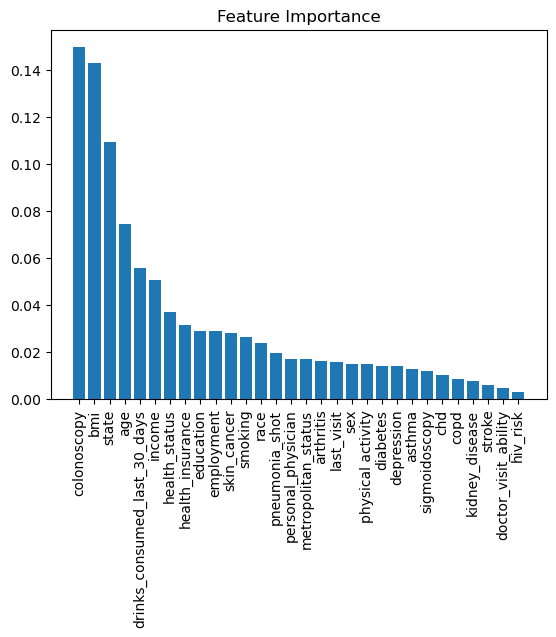


Random Forest with SMOTENC
Accuracy: 0.70
F1 score: 0.6789239793871067
ROC AUC score: 0.7683797856660086
Sensitivity: 0.6288488867835149
Precision: 0.5538172715894869
              precision    recall  f1-score   support

           0       0.80      0.74      0.77     16608
           1       0.55      0.63      0.59      8444

    accuracy                           0.70     25052
   macro avg       0.68      0.69      0.68     25052
weighted avg       0.72      0.70      0.71     25052

Confusion Matrix:
[[12330  4278]
 [ 3134  5310]]
Feature Importances:
0.11194458826932296: bmi
0.097038167018411: state
0.09129206025219397: age
0.05672096950790625: drinks_consumed_last_30_days
0.05185413289049846: income
0.04849943083875507: health_insurance
0.04800224622822918: colonoscopy
0.04725489234554805: sigmoidoscopy
0.04178333737300689: health_status
0.040740950333807174: employment
0.033903413893143906: skin_cancer
0.03360918952194243: education
0.029769644602027467: race
0.02838066076910

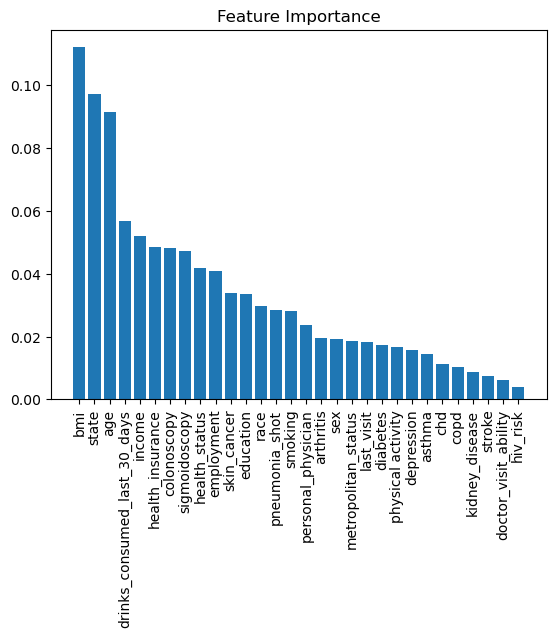

In [19]:
print("Decision Tree with SMOTENC")
clf = decision_tree(X_resampled, X_test, y_resampled, y_test, return_clf=True)
print ("Feature Importances:")
feature_importance(clf)

print("\nRandom Forest with SMOTENC")
clf = random_forest(X_resampled, X_test, y_resampled, y_test, return_clf=True)
print ("Feature Importances:")
feature_importance(clf)

In [20]:
threshold = 0.1
important_features = []
for feature_name, importance in sorted(zip(clf.feature_importances_, X.columns), reverse=True):
    if importance > threshold:
        important_features.append(importance)
print(f"Important features: {important_features}")


TypeError: '>' not supported between instances of 'str' and 'float'

In [23]:
#show prediction for a single patient
print("Prediction for a single patient")
patient = X_test.iloc[1]
#remove the target row
print(patient)
print("Actual value:", y_test.iloc[1])
print("Predicted value:", clf.predict([patient]))
print("Predicted probability:", clf.predict_proba([patient]))

Prediction for a single patient
state                            0.00
health_insurance                10.00
personal_physician               3.00
doctor_visit_ability             1.00
last_visit                       5.00
stroke                           1.00
skin_cancer                      1.00
copd                             1.00
depression                       1.00
kidney_disease                   1.00
diabetes                         1.00
employment                       2.00
pneumonia_shot                   1.00
hiv_risk                         1.00
metropolitan_status              0.00
health_status                    3.00
physical activity                2.00
chd                              0.00
asthma                           3.00
arthritis                        1.00
race                             2.00
sex                              1.00
colonoscopy                      0.00
sigmoidoscopy                    0.00
age                              4.00
bmi               

/Users/rohithpydi/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/rohithpydi/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [11]:
#USE F1 MACRO INSTEAD OF ACCURACY
#RECALL
#ROC AND AOC
#more false positives than false negatives
#more sensitivisity than specificity instead of false positives/negatives


In [12]:
#consider converting numerical to categorical via bins
#random forest feature selection
#one hot encoding
#frequency encoding
#chi square
#try dividing data set by age
